# Diabetes Prediction
#### Data Source
From Kaggle by user Mohammed Mustafa 
Link https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
### Description
The data contains predictors `gender`, `age`, `hypertension`, `heart_disease`, `smoking_history`, `bmi`, `HbA1c_level`, `blood_glucose_level`, and the response `diabetes` for 100000 patients.
- `gender` may have one of three qualitative values `female`, `male`, or `other`
- `age` may be any integer value from 0-80
- `hypertension` is one-hot encoded where 0 and 1 are the absense and presence of hypertension exhibited by the patient, respectively
- `heart_disease` is one-hot encoded where 0 and 1 are the absense and presence of heart disease exhibited by the patient, respectively
- `smoking_history` may be one of six qualitative values, `not current`, `former`, `No Info`, `current`, `never`, and `ever`
- `bmi` is the body mass index of the patient and may be any real number between 10 and 95.7
- `HbA1c_level` is the level of hemoglobic A1c measured in the pateints blood and may be a real number from 3.5 to 9
- `blood_glucose_level` is the level of glucose in the patient's bloodstream and may be a real nmumber from 80 to 300
- `diabetes` is one-hot encoded where 0 and 1 are the absense and presence of diabetes exhibited by the patient, respectively

### Training and Test Split
The data will be randomly split into training and test data. 10% of the data will be removed exclusively for model testing and analysis toward the end of the experiment. The remaining 90% of data will be used for training purposes. 

## Centralized and Federated Environments
### Centralized
In this scenario, all data is stored in one location and training using a single logistic regression model. This model will be analyzed and provide a baseline against which the federated learning tests will be compared.

### Federated
In this scenario, the training data is randomly distributed into 8 different smaller sets which will be used to train 8 invididual logistic regression models concurrently. This will simulate 8 different clients training on their own local data. Initially, the bins will contain roughly the same amount of data. To explore the effects of an imbalanced distribution of data, another experiment will assess model training when this data is not equally distributed across the clients. It is important to note that between training rounds, the clients will send model parameters (in this case the model coefficients) to a central process acting as a server. This server will aggregate model updates to generate a new global model which all clients will use to update their own local model before the next round of training.


## Installing Dependencies

In [1]:
#!pip install numpy pandas sklearn

## Initial Data Processing

In [2]:
import os

# Change directory to the location holding the data
os.chdir('../data')
os.getcwd()

'C:\\Repositories\\COMP8590-StatisticalLearning\\data'

In [3]:
import random
from math import ceil
import pandas as pd
import sys
from sklearn import preprocessing

random.seed(0)
# Split the data, 90% Training, 10% Test
# Test data only used for final evaluation
# First need to create dummy variables and scale data
raw_df = pd.read_csv('diabetes_prediction_dataset.csv')

# As an additional preprocessing task, we need to create dummy variables for the `smoking_history` predictor.
# This is necessary so that we can create 6 dummy dummy variables that will be one-hot encoded for each of the
# possible categorical values of `smoking_history`. The new dummy variables are `smoking_history_No Info`,
# `smoking_history_current`, `smoking_history_ever`, `smoking_history_former`, `smoking_history_never`, and
# `smoking_history_not current`.
smk_dummies = pd.get_dummies(raw_df['smoking_history'], dtype=int)
raw_df = raw_df.drop(columns=['smoking_history'])
for column in smk_dummies.columns:
        raw_df.insert(7, 'smoking_history_' + column, smk_dummies[column])

# The same process must also be performed for the `gender` predictor. We will create three dummy variables, 
# `female`, `male`, and `other`, and one-hot encode them in a similar fashion to above
gnd_dummies = pd.get_dummies(raw_df['gender'], dtype=int)
raw_df = raw_df.drop(columns=['gender'])
for column in gnd_dummies.columns:
        raw_df.insert(0, 'gender_' + column, gnd_dummies[column])

# Scale the data to range [0, 1]
scaler = preprocessing.MinMaxScaler()
raw_df = pd.DataFrame(scaler.fit_transform(raw_df), columns=raw_df.columns)

# Save the processed data
raw_df.to_csv('diabetes_prediction_dataset_processed.csv', index=False)

# Count lines in file
data_file = open('diabetes_prediction_dataset_processed.csv')
lines_data = sum(1 for line in data_file)

# Reset file pointer
data_file.seek(0)

# Randomly Select Train and test Samples
select_test = random.sample(range(1, lines_data), ceil(lines_data * 0.1))
select_train = [row for row in range(1, lines_data) if row not in select_test]

# Load in test data
train_df = pd.read_csv('diabetes_prediction_dataset_processed.csv', skiprows=select_test)
test_df = pd.read_csv('diabetes_prediction_dataset_processed.csv', skiprows=select_train)

# Confirm data added correctly
#print(train_df.shape)
#print(train_df.head())
#print(test_df.shape)
#print(test_df)

# For consistency later and to avoid repeating this step, we will save the training and test data to separate files
train_df.to_csv('diabetes_prediction_dataset_train.csv', index=False)
test_df.to_csv('diabetes_prediction_dataset_test.csv', index=False) # Note, this will be reserved exclusively for model analysis AFTER training

# Centralized Logistic Regression
## Scenario
In this scenario, we create a logistic regression model that is trained to predict the reponse `diabetes` using the predictors `gender`, `age`, `hypertension`, `heart_disease`, `smoking_history`, `bmi`, `HbA1c_level`, and `blood_glucose_level`. We assume that all training data and the training task itself is centralized to one system. Here, we train the model using k-fold cross-validation.

### Implementation
#### Data Processing
We begin by importing the necessary packages and processing the training data. Here we require the training data to be split again into training and validation data. Here, the traininig set is relatively large (~90000 samples) so we implement k-fold cross-validation where k=10. For this task, scikit-learn fortunately has a built-in function that will train the logistic regession model with cross validation.

In [4]:
# imports 
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# Data Preparation, get training data, isolate into predictors and response columns
cent_train = pd.read_csv('diabetes_prediction_dataset_train.csv')
X_train = cent_train.loc[:, cent_train.columns != 'diabetes'].to_numpy()
Y_train = cent_train.loc[:, cent_train.columns == 'diabetes'].to_numpy().ravel()

# Confirm shape should be cent_train: (n, 16), X_train: (n, 15), and Y_train (n,) where n is ~90000
print('Size:\n\tcent_train:\t{}\n\tX_train:\t{}\n\tY_train:\t{}'.format(cent_train.shape, X_train.shape, Y_train.shape))

Size:
	cent_train:	(89999, 16)
	X_train:	(89999, 15)
	Y_train:	(89999,)


#### Model Definition and Training
Here, the logistic regression model is defined. `LogisticRegressionCV` has a `cv` parameter which governs the number of folds in the cross-validation method. Because we are performing 10-fold cross-validation, we set `cv=10`. Finally, we tell select to use the Stochastic Average Gradient decent algorithm as per scikit's recommendations since it runs faster for larger datasets. Therefore, we set `solver='sag'`. SAG is also only compatible with the L2 penalty term so we need to set the `penalty` parameter to `penalty='l2'`. `random_state` is another parameter which should be set when using SAG. We set `random_state=0`. We also set the `max_iter` parameter to `10000` which halts learning when the model converges or when the maximum number of training iterations/epochs has been reached; whichever comes first. The `n_jobs` parameter is set to 10 to enable multithreaded training on 5 CPU cores. This speeds up model training by simultaneously training the model with 5 of the 10 folds. `verbose=1` simply allows us to view the training progress. 

In [5]:
# Model Definition
cModel_LR = LogisticRegressionCV(cv=10, solver='sag', max_iter=10000, random_state=0, penalty='l2', n_jobs=10, verbose=0)  # set verbose=1 to view output

In [6]:
# Model Training
cModel_LR.fit(X_train, Y_train)

LogisticRegressionCV(cv=10, max_iter=10000, n_jobs=10, random_state=0,
                     solver='sag')

#### Centralized Model Brief Evaluation

In [7]:
cent_test = pd.read_csv('diabetes_prediction_dataset_test.csv')
X_test = cent_test.loc[:, cent_test.columns != 'diabetes'].to_numpy()
Y_test = cent_test.loc[:, cent_test.columns == 'diabetes'].to_numpy().ravel()
Y_pred = cModel_LR.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      9126
         1.0       0.90      0.61      0.73       875

    accuracy                           0.96     10001
   macro avg       0.93      0.80      0.85     10001
weighted avg       0.96      0.96      0.96     10001



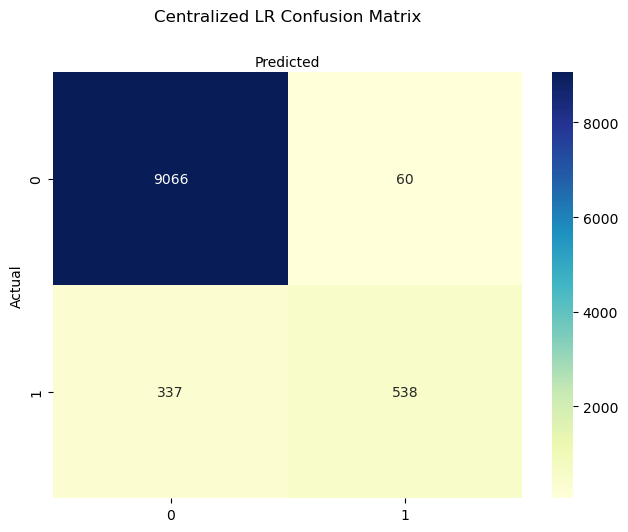

In [8]:
from sklearn import metrics
from sklearn.metrics import classification_report, mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Print the confusion matrix
cent_CM = metrics.confusion_matrix(Y_test, Y_pred)
classes = ['Negative', 'Positive']
_, axis = plt.subplots()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
sns.heatmap(pd.DataFrame(cent_CM), fmt='g', cmap='YlGnBu', annot=True)
axis.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Centralized LR Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Print the Classification Report
print(classification_report(Y_test, Y_pred))

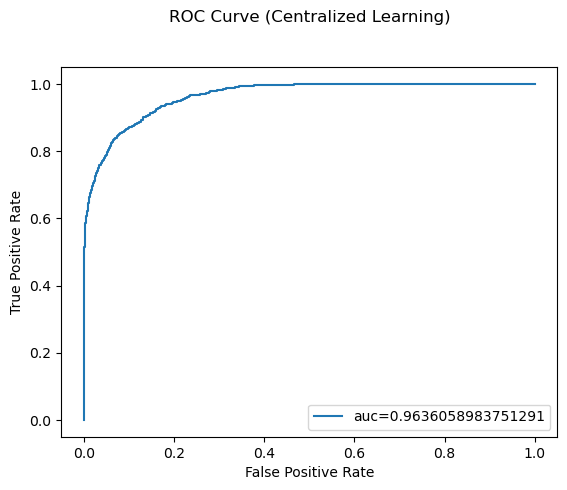

In [9]:
# Print the ROC and AUC score
Y_prob = cModel_LR.predict_proba(X_test)[::,1]
n_pred, p_pred, _ = metrics.roc_curve(Y_test, Y_prob)
auc = metrics.roc_auc_score(Y_test, Y_prob)
plt.plot(n_pred, p_pred, label="auc="+str(auc))
plt.title('ROC Curve (Centralized Learning)', y=1.1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Federated Logistic Regression
## Scenario
Like before, we create a logistic regression model that is trained to predict the reponse `diabetes` using the predictors `gender`, `age`, `hypertension`, `heart_disease`, `smoking_history`, `bmi`, `HbA1c_level`, and `blood_glucose_level`. This time, however, we assume that all training data and the training task itself is distributed across a network of 8 clients. A server receives model udpates from the clients and aggregates them to create a new global model. The aggregation method used closely follows the original aggregation algorithm, FedAVG, proposed by McMahan <i>et al</i><sup>1</sup>. It is worth noting that because the number of clients is relatively small, all clients will contribute to aggregation in each round as opposed to randomly selected models.

1. McMahan, B., Moore, E., Ramage, D., Hampson, S. &amp; Arcas, B.A.y.. (2017). Communication-Efficient Learning of Deep Networks from Decentralized Data. <i>Proceedings of the 20th International Conference on Artificial Intelligence and Statistics</i>, in <i>Proceedings of Machine Learning Research</i> 54:1273-1282 Available from https://proceedings.mlr.press/v54/mcmahan17a.html.

### Balanced Implementation
#### Data Processing
To simulate training on various client devices, data is equally divided into 8 subsets at random. 8 individual models will be trained exclusively on their respective subsets. On the client side, we require the training data to be split again into training and validation data. The traininig sets are still relatively large (~11250 samples) so we implement k-fold cross-validation where k=10, similarly to above.

In [10]:
# Read in the data to a new datafram
fed_train_df = pd.read_csv('diabetes_prediction_dataset_train.csv')

# Randomly shuffle the samples in the dataframe and then split it into 8 client dataframes
fed_train_shuffled_df = fed_train_df.sample(frac=1)
client_set_df = np.array_split(fed_train_shuffled_df, 8)

# Save each fraction to a new csv file
client_no = 0
for client_df in client_set_df:
    client_df.to_csv('diabetes_prediction_dataset_CLIENT_' + str(client_no) + '.csv', index=False)
    client_no += 1

In [11]:
# Data Preparation, get training data, isolate into predictors and response columns
fed_train = []  # An array of pd.DataFrames; each dataframe will store predictors and response columns for a respective client
fed_X_train = []  # An array of pd.DataFrames; each dataframe will store only predictors columns for a respective client 
fed_Y_train = []  # An array of pd.DataFrames; each dataframe will store only the response column for a respective client
for i in range(8):
    fed_train.append(pd.read_csv('diabetes_prediction_dataset_CLIENT_' + str(i) + '.csv'))
    fed_X_train.append(fed_train[i].loc[:, fed_train[i].columns != 'diabetes'].to_numpy())
    fed_Y_train.append(fed_train[i].loc[:, fed_train[i].columns == 'diabetes'].to_numpy().ravel())
    
    # Confirm shape should be cent_train: (n, 16), X_train: (n, 15), and Y_train (n,) where n is ~90000
    #print('Size:\n\tfed_train[{}]:\t{}\n\tfed_X_train[{}]:\t{}\n\tfed_Y_train[{}]:\t{}'.format(i, fed_train[i].shape, i, fed_X_train[i].shape, i, fed_Y_train[i].shape))

#### Model Definition and Training
In the federated setting, we define 8 logistic regression models with the same parameters as in the above centralized implementation. After defining the models for each client, we also define an aggregation function which will occur at regular intervals after 100 epochs of client training. This will occur for a maximum of 100 federated learning cycles (for a total of 10000 client training epochs).

In [12]:
# Define Models
# Define an array of models each representing a single client
fedModels_LR = []
for i in range(8):
    fedModels_LR.append(LogisticRegressionCV(cv=10, solver='sag', max_iter=100, random_state=0, penalty='l2', n_jobs=10, verbose=0))  # set verbose=1 to view output
    

# Define an update class
class ModelUpdate:
    def __init__(self, coef_, intercept_, C_):
        self.coef_ = coef_
        self.intercept_ = intercept_
        self.C_ = C_


# Define Aggregation Function
def FedAVG(updates):
    avg_coef_ = np.empty(shape=updates[0].coef_.shape)
    avg_intercept_ = np.empty(shape=updates[0].intercept_.shape)
    avg_C_ = np.empty(shape=updates[0].C_.shape)
    
    for update in updates:
        avg_coef_ += update.coef_
        avg_intercept_ += update.intercept_
        avg_C_ += update.C_
    
    global_update = ModelUpdate(coef_=avg_coef_/len(updates),
                           intercept_=avg_intercept_/len(updates),
                           C_=avg_C_/len(updates))
    
    return global_update

In [13]:
# Training
# Note:  Because the individual models fail to converge initially, the ConvergenceWarning generated by sklearn's fit() function is surpressed in the output cell below.
#        For this reason, the training code is wrapped in `with warnings.catch_warnings():....`
import warnings
from tqdm import tqdm_notebook

# Define the Global Model (it is not trained directly)
fedModel_GLOBAL_LR = LogisticRegressionCV(cv=10, solver='sag', max_iter=10000, random_state=0, penalty='l2', n_jobs=10, verbose=0)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # 100 Federated Learning Cycles
    for i in tqdm_notebook(range(100), desc='Training...'):
        # Generate and array of updates
        updates = []
        # Each Client trains on it's own data for 100 epochs
        for j in tqdm_notebook(range(8), desc='Client', leave=False):
            fedModels_LR[j].fit(fed_X_train[j], fed_Y_train[j])
            # Generate model update with model parameters
            updates.append(ModelUpdate(coef_=fedModels_LR[j].coef_,
                                       intercept_=fedModels_LR[j].intercept_,
                                       C_=fedModels_LR[j].C_)
                          )
        
        # Aggregate client updates and generate global model
        global_update = FedAVG(updates)
        
        # Update the global model
        fedModel_GLOBAL_LR.coef_ = global_update.coef_
        fedModel_GLOBAL_LR.intercept_ = global_update.intercept_
        fedModel_GLOBAL_LR.C_ = global_update.C_
        fedModel_GLOBAL_LR.classes_ = fedModels_LR[0].classes_
            
        # Update client local models before beginning next round of federated learning
        for client in fedModels_LR:
            client.coef_ = global_update.coef_
            client.intercept_ = global_update.intercept_
            client.C_ = global_update.C_
    

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

#### Federated Model Brief Evaluation

In [14]:
# Load the same test data as the centralized experiment
fed_test = pd.read_csv('diabetes_prediction_dataset_test.csv')
fed_X_test = fed_test.loc[:, fed_test.columns != 'diabetes'].to_numpy()
fed_Y_test = fed_test.loc[:, fed_test.columns == 'diabetes'].to_numpy().ravel()
fed_Y_pred = fedModel_GLOBAL_LR.predict(fed_X_test)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      9126
         1.0       0.91      0.61      0.73       875

    accuracy                           0.96     10001
   macro avg       0.94      0.80      0.85     10001
weighted avg       0.96      0.96      0.96     10001



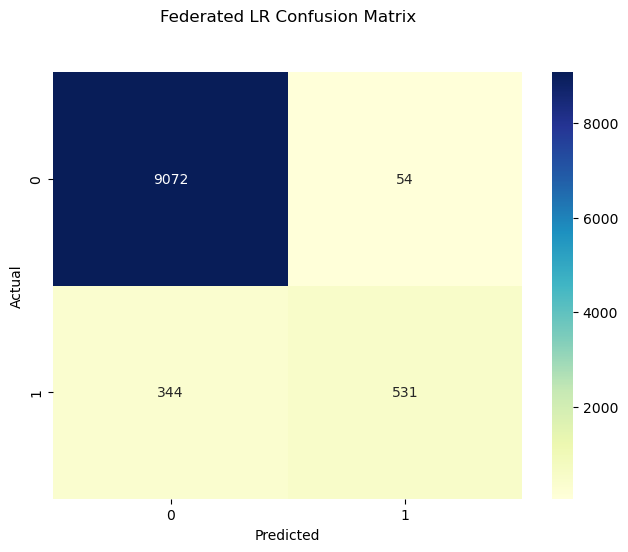

In [15]:
# Print the confusion matrix
fed_CM = metrics.confusion_matrix(fed_Y_test, fed_Y_pred)
classes = ['Negative', 'Positive']
_, fed_axis = plt.subplots()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
sns.heatmap(pd.DataFrame(fed_CM), fmt='g', cmap='YlGnBu', annot=True)
axis.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Federated LR Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Print the Classification Report
print(classification_report(fed_Y_test, fed_Y_pred))

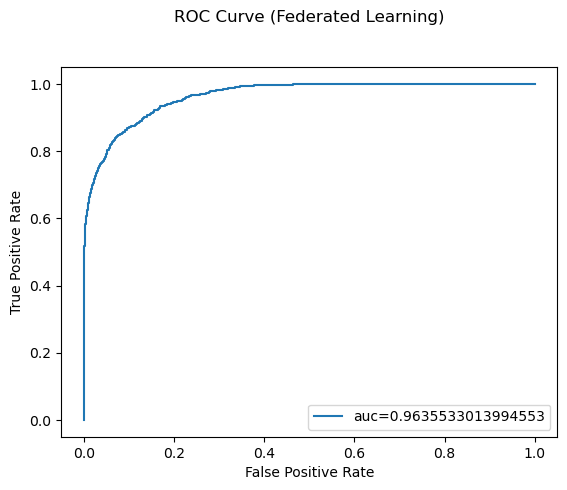

In [16]:
# Print the ROC and AUC score
fed_Y_prob = fedModel_GLOBAL_LR.predict_proba(fed_X_test)[::,1]
fed_n_pred, fed_p_pred, _ = metrics.roc_curve(fed_Y_test, fed_Y_prob)
fed_auc = metrics.roc_auc_score(fed_Y_test, fed_Y_prob)
plt.plot(fed_n_pred, fed_p_pred, label="auc="+str(fed_auc))
plt.title('ROC Curve (Federated Learning)', y=1.1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Unbalanced Implementation
#### Data Processing
To simulate a more realistic scenario where client devices hold an unbalanced distribution of data, data is unevenly divided into 8 subsets at random. 8 individual models will be trained exclusively on their respective subsets, just like the previous experiment. The only change is that some clients hold much more data than others.

In [17]:
import math
# Read in the data to a new datafram
ufed_train_df = pd.read_csv('diabetes_prediction_dataset_train.csv')

# Randomly shuffle the samples in the dataframe
ufed_train_shuffled_df = ufed_train_df.sample(frac=1)
client_set_df = ufed_train_shuffled_df

# Dirichlet Distribution to generate list of random numbers summing to 1
d_dist = np.random.dirichlet(np.ones(8), size=1)

for i in range(8):
    # multiply random number by number of samples to get size of dataset
    n = math.floor(d_dist[0][i] * ufed_train_df.shape[0])
    
    # randomly sample n rows from the shuffled data
    client_df = client_set_df.sample(n=n, replace=False, random_state=1)
    client_set_df.drop(client_df.index, inplace=True)
    
    # if some samples remain, add them to the last client's dataset
    if i == 7 and client_set_df.shape[0] > 0:
        client_df = pd.concat([client_df, client_set_df])
        
    # Save each fraction to a new csv file
    client_df.to_csv('diabetes_prediction_dataset_UNBALANCED_CLIENT_' + str(i) + '.csv', index=False)

In [18]:
# Data Preparation, get training data, isolate into predictors and response columns
ufed_train = []  # An array of pd.DataFrames; each dataframe will store predictors and response columns for a respective client
ufed_X_train = []  # An array of pd.DataFrames; each dataframe will store only predictors columns for a respective client 
ufed_Y_train = []  # An array of pd.DataFrames; each dataframe will store only the response column for a respective client
for i in range(8):
    ufed_train.append(pd.read_csv('diabetes_prediction_dataset_UNBALANCED_CLIENT_' + str(i) + '.csv'))
    ufed_X_train.append(ufed_train[i].loc[:, ufed_train[i].columns != 'diabetes'].to_numpy())
    ufed_Y_train.append(ufed_train[i].loc[:, ufed_train[i].columns == 'diabetes'].to_numpy().ravel())
    
    # Confirm shape should be cent_train: (n, 16), X_train: (n, 15), and Y_train (n,) where n is ~90000
    #print('Size:\n\tfed_train[{}]:\t{}\n\tfed_X_train[{}]:\t{}\n\tfed_Y_train[{}]:\t{}'.format(i, fed_train[i].shape, i, fed_X_train[i].shape, i, fed_Y_train[i].shape))

#### Model Definition and Training
In the federated setting, we define 8 logistic regression models with the same parameters as in the above centralized and federated implementations. An aggregation function will occur at regular intervals after 100 epochs of client training. Training will occur for a maximum of 100 federated learning cycles (for a total of 10000 client training epochs).

In [19]:
# Define Models
# Define an array of models each representing a single client
ufedModels_LR = []
for i in range(8):
    ufedModels_LR.append(LogisticRegressionCV(cv=10, solver='sag', max_iter=100, random_state=0, penalty='l2', n_jobs=10, verbose=0))  # set verbose=1 to view output

In [20]:
# Training
# Note:  Because the individual models fail to converge initially, the ConvergenceWarning generated by sklearn's fit() function is surpressed in the output cell below.
#        For this reason, the training code is wrapped in `with warnings.catch_warnings():....`
import warnings
from tqdm import tqdm_notebook

# Define the Global Model (it is not trained directly)
ufedModel_GLOBAL_LR = LogisticRegressionCV(cv=10, solver='sag', max_iter=10000, random_state=0, penalty='l2', n_jobs=10, verbose=0)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # 100 Federated Learning Cycles
    for i in tqdm_notebook(range(100), desc='Training...'):
        # Generate and array of updates
        updates = []
        # Each Client trains on it's own data for 100 epochs
        for j in tqdm_notebook(range(8), desc='Client', leave=False):
            ufedModels_LR[j].fit(ufed_X_train[j], ufed_Y_train[j])
            # Generate model update with model parameters
            updates.append(ModelUpdate(coef_=ufedModels_LR[j].coef_,
                                       intercept_=ufedModels_LR[j].intercept_,
                                       C_=ufedModels_LR[j].C_)
                          )
        
        # Aggregate client updates and generate global model
        global_update = FedAVG(updates)
        
        # Update the global model
        ufedModel_GLOBAL_LR.coef_ = global_update.coef_
        ufedModel_GLOBAL_LR.intercept_ = global_update.intercept_
        ufedModel_GLOBAL_LR.C_ = global_update.C_
        ufedModel_GLOBAL_LR.classes_ = ufedModels_LR[0].classes_
            
        # Update client local models before beginning next round of federated learning
        for client in ufedModels_LR:
            client.coef_ = global_update.coef_
            client.intercept_ = global_update.intercept_
            client.C_ = global_update.C_
    

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

#### Unbalanced Federated Model Brief Evaluation

In [21]:
# Load the same test data as the centralized experiment
ufed_test = pd.read_csv('diabetes_prediction_dataset_test.csv')
ufed_X_test = ufed_test.loc[:, ufed_test.columns != 'diabetes'].to_numpy()
ufed_Y_test = ufed_test.loc[:, ufed_test.columns == 'diabetes'].to_numpy().ravel()
ufed_Y_pred = ufedModel_GLOBAL_LR.predict(ufed_X_test)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      9126
         1.0       0.89      0.62      0.73       875

    accuracy                           0.96     10001
   macro avg       0.93      0.81      0.85     10001
weighted avg       0.96      0.96      0.96     10001



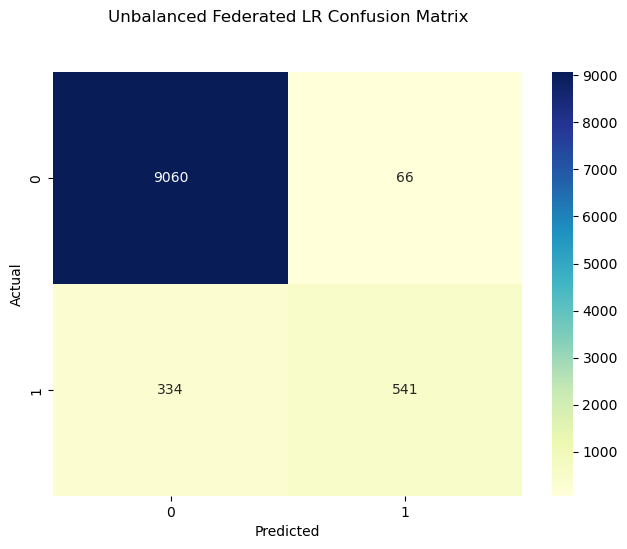

In [22]:
# Print the confusion matrix
ufed_CM = metrics.confusion_matrix(ufed_Y_test, ufed_Y_pred)
classes = ['Negative', 'Positive']
_, ufed_axis = plt.subplots()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
sns.heatmap(pd.DataFrame(ufed_CM), fmt='g', cmap='YlGnBu', annot=True)
axis.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Unbalanced Federated LR Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Print the Classification Report
print(classification_report(ufed_Y_test, ufed_Y_pred))

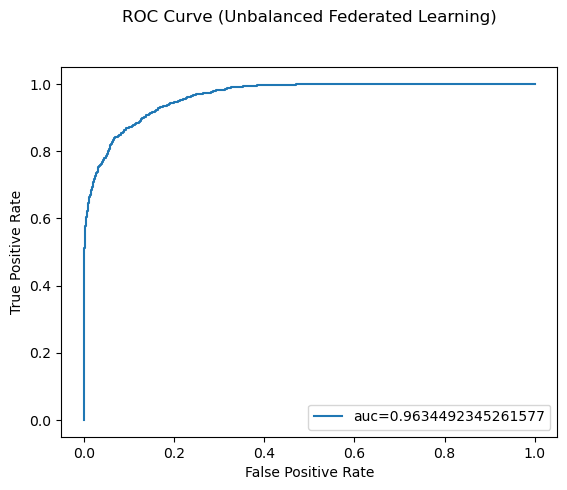

In [23]:
# Print the ROC and AUC score
ufed_Y_prob = ufedModel_GLOBAL_LR.predict_proba(ufed_X_test)[::,1]
ufed_n_pred, ufed_p_pred, _ = metrics.roc_curve(ufed_Y_test, ufed_Y_prob)
ufed_auc = metrics.roc_auc_score(ufed_Y_test, ufed_Y_prob)
plt.plot(ufed_n_pred, ufed_p_pred, label="auc="+str(ufed_auc))
plt.title('ROC Curve (Unbalanced Federated Learning)', y=1.1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [24]:
for dataset in ufed_X_train:
    print(dataset.shape)

(806, 15)
(5678, 15)
(30776, 15)
(4910, 15)
(22595, 15)
(8202, 15)
(15918, 15)
(1114, 15)


### Unbalanced Implementation with Client Downtime
#### Data Processing
In a realworld implementation, we can expect that many clients may only have intermitent or low-bandwidth connections to the server in addition to an unbalanced distribution of data. In this final experiment data is unevenly divided into 8 subsets at random. As with previous experiments, 8 individual models will be trained exclusively on their respective subsets. In addition to unbalanced data distributions, we simulate intermitent communication with the server by leaving some models out of the aggregation step. In this scenario, we propose that clients are available 80% of the time while the other 20% they are experiencing downtime. It is important to note that the downtime means the client neither contributes to aggregation nor receives a global model update. Models continue <i>local model</i> training regardless of downtime.

To maintain consistency with the previous experiment, we use the same unablanced data distribution.

In [28]:
# Data Preparation, use same training data and data distribution as the previous experiment
udfed_train = []  # An array of pd.DataFrames; each dataframe will store predictors and response columns for a respective client
udfed_X_train = []  # An array of pd.DataFrames; each dataframe will store only predictors columns for a respective client 
udfed_Y_train = []  # An array of pd.DataFrames; each dataframe will store only the response column for a respective client
    
# Confirm shape should be cent_train: (n, 16), X_train: (n, 15), and Y_train (n,) where n is ~90000
for i in range(8):
    udfed_train.append(pd.read_csv('diabetes_prediction_dataset_UNBALANCED_CLIENT_' + str(i) + '.csv'))
    udfed_X_train.append(udfed_train[i].loc[:, udfed_train[i].columns != 'diabetes'].to_numpy())
    udfed_Y_train.append(udfed_train[i].loc[:, udfed_train[i].columns == 'diabetes'].to_numpy().ravel())
    #print('Size:\n\tfed_train[{}]:\t{}\n\tfed_X_train[{}]:\t{}\n\tfed_Y_train[{}]:\t{}'.format(i, udfed_train[i].shape, i, udfed_X_train[i].shape, i, udfed_Y_train[i].shape))

#### Model Definition and Training
In the federated setting, we define 8 logistic regression models with the same parameters as in the above centralized and federated implementations. An aggregation function will occur at regular intervals after 100 epochs of client training. Training will occur for a maximum of 100 federated learning cycles (for a total of 10000 client training epochs).

In [29]:
# Define Models
# Define an array of models each representing a single client
udfedModels_LR = []
for i in range(8):
    udfedModels_LR.append(LogisticRegressionCV(cv=10, solver='sag', max_iter=100, random_state=0, penalty='l2', n_jobs=10, verbose=0))  # set verbose=1 to view output

In [30]:
# Training
# Note:  Because the individual models fail to converge iniclient_downtimes ConvergenceWarning generated by sklearn's fit() function is surpressed in the output cell below.
#        For this reason, the training code is wrapped in `with warnings.catch_warnings():....`
import warnings
from tqdm import tqdm_notebook

# Probability of not experiening downtime: 80%
p = 0.8

# Define the Global Model (it is not trained directly)
udfedModel_GLOBAL_LR = LogisticRegressionCV(cv=10, solver='sag', max_iter=10000, random_state=0, penalty='l2', n_jobs=10, verbose=0)

# An array to record the number of times each client experiences downtime
client_downtimes = [0, 0, 0, 0, 0, 0 ,0 ,0]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # 100 Federated Learning Cycles
    for i in tqdm_notebook(range(100), desc='Training...'):
        # Generate and array of updates
        updates = []
        
        # List of clients which cannot be updated due to downtime
        downtime = []
        
        # Each Client trains on it's own data for 100 epochs
        for j in tqdm_notebook(range(8), desc='Client', leave=False):
            udfedModels_LR[j].fit(udfed_X_train[j], udfed_Y_train[j])
            # Generate model update with model parameters
            # Update is RANDOMLY appended based on probability p = 0.8
            if np.random.binomial(1,p) == 1: 
                updates.append(ModelUpdate(coef_=udfedModels_LR[j].coef_,
                                           intercept_=udfedModels_LR[j].intercept_,
                                           C_=udfedModels_LR[j].C_)
                              )
            else:
                # Keep track of clients which experienced downtime
                downtime.append(j)
                client_downtimes[j] += 1
                
        # Aggregate client updates and generate global model
        global_update = FedAVG(updates)
        
        # Update the global model
        udfedModel_GLOBAL_LR.coef_ = global_update.coef_
        udfedModel_GLOBAL_LR.intercept_ = global_update.intercept_
        udfedModel_GLOBAL_LR.C_ = global_update.C_
        udfedModel_GLOBAL_LR.classes_ = ufedModels_LR[0].classes_
            
        # Update client local models before beginning next round of federated learning IFF they are not experiencing downtime this round
        for client in udfedModels_LR:
            if udfedModels_LR.index(client) not in downtime:
                client.coef_ = global_update.coef_
                client.intercept_ = global_update.intercept_
                client.C_ = global_update.C_
    

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

Client:   0%|          | 0/8 [00:00<?, ?it/s]

#### Unbalanced Federated Model Brief Evaluation

In [32]:
# Print the number of times each client experienced downtime
print("CLIENT DOWNTIME")
for i in range(8):
    print("Client {}: {} times".format(i, client_downtimes[i]))

CLIENT DOWNTIME
Client 0: 19 times
Client 1: 14 times
Client 2: 19 times
Client 3: 18 times
Client 4: 22 times
Client 5: 20 times
Client 6: 13 times
Client 7: 15 times


In [33]:
# Load the same test data as the centralized experiment
udfed_test = pd.read_csv('diabetes_prediction_dataset_test.csv')
udfed_X_test = udfed_test.loc[:, udfed_test.columns != 'diabetes'].to_numpy()
udfed_Y_test = udfed_test.loc[:, udfed_test.columns == 'diabetes'].to_numpy().ravel()
udfed_Y_pred = udfedModel_GLOBAL_LR.predict(udfed_X_test)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9126
         1.0       0.87      0.63      0.73       875

    accuracy                           0.96     10001
   macro avg       0.92      0.81      0.86     10001
weighted avg       0.96      0.96      0.96     10001



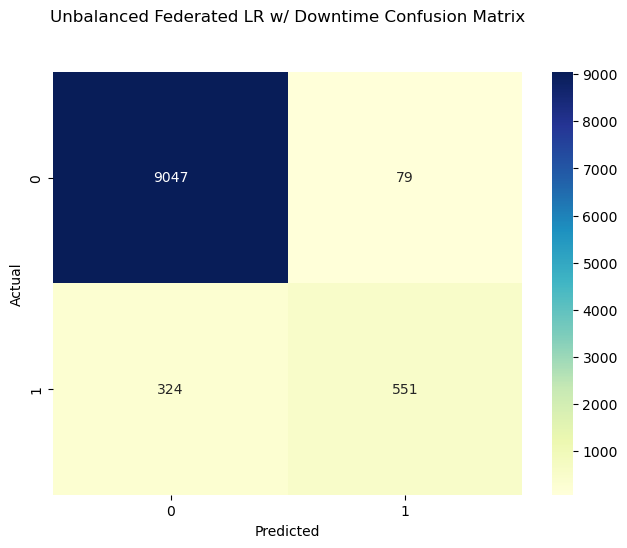

In [34]:
# Print the confusion matrix
udfed_CM = metrics.confusion_matrix(udfed_Y_test, udfed_Y_pred)
classes = ['Negative', 'Positive']
_, udfed_axis = plt.subplots()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
sns.heatmap(pd.DataFrame(udfed_CM), fmt='g', cmap='YlGnBu', annot=True)
axis.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Unbalanced Federated LR w/ Downtime Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Print the Classification Report
print(classification_report(udfed_Y_test, udfed_Y_pred))

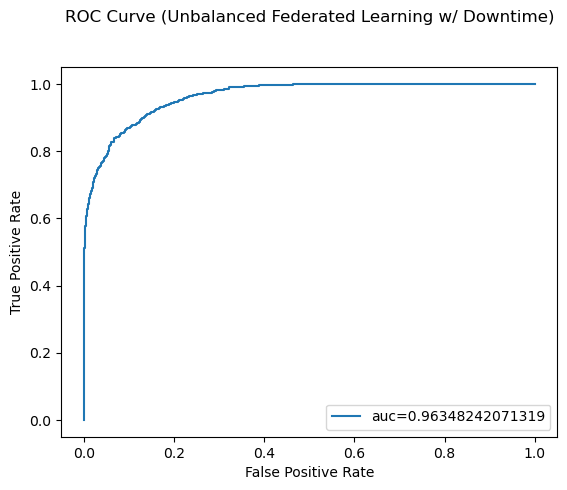

In [35]:
# Print the ROC and AUC score
udfed_Y_prob = udfedModel_GLOBAL_LR.predict_proba(udfed_X_test)[::,1]
udfed_n_pred, udfed_p_pred, _ = metrics.roc_curve(udfed_Y_test, udfed_Y_prob)
udfed_auc = metrics.roc_auc_score(udfed_Y_test, udfed_Y_prob)
plt.plot(udfed_n_pred, udfed_p_pred, label="auc="+str(udfed_auc))
plt.title('ROC Curve (Unbalanced Federated Learning w/ Downtime)', y=1.1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [36]:
for dataset in udfed_X_train:
    print(dataset.shape)

(806, 15)
(5678, 15)
(30776, 15)
(4910, 15)
(22595, 15)
(8202, 15)
(15918, 15)
(1114, 15)
